In [64]:
import yaml
from random import random

yaml_file = {}
with open("output-1-251/output-100-120.yaml") as file:
    try:
        yaml_file = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

yaml_file_keys = list(yaml_file.keys())
yfk_len = len(yaml_file_keys)
test_file = {}
num_tests = 10
for _ in range(num_tests):
    idx = int(random()*yfk_len)
    file_key = yaml_file_keys[idx]
    test_file[file_key] = yaml_file[file_key]
    imgGT = yaml_file[file_key]['imgGT']
    test_file[imgGT] = yaml_file[imgGT]
    
with open(f'test.yaml', 'w') as file:
    yaml.dump(test_file, file)

In [75]:
import torch
import math
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from Dataset import createDataset
from Network import Generator
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from LightCNN import LightCNN_29Layers_v2
from config import settings
import numpy as np
from math import log10, sqrt

In [76]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()
     
def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window


def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret


In [77]:
def get_psnr(original, compressed):
    # Convert images to numpy arrays
    original_data = np.array(original, dtype=np.float64)
    compressed_data = np.array(compressed, dtype=np.float64)

    # Calculate the mean squared error (MSE)
    mse = np.mean((original_data - compressed_data) ** 2)

    # If MSE is zero, return infinity
    if mse == 0:
        return float('inf')

    # Calculate the maximum possible pixel value
    max_pixel_value = np.max(original_data)

    # Calculate the PSNR
    psnr_value = 20 * log10(max_pixel_value / sqrt(mse))

    return psnr_value

def parse_args():
    parser = argparse.ArgumentParser(description='''Show the output of trained TP-GAN on the input images.
                                                    Input is not sanitized, please be nice. ''')
    parser.add_argument('-l', '--img-list', type=str, default='test.yml', help='yaml file of input processed input images')
    parser.add_argument('-d', '--img-dir', type=str, default='E:/major_project/data/unzips', help='directory of processed input images')
    parser.add_argument('-m', '--model', type=str, default='model_generator_20.pth', help='path to generator checkpoint')
    parser.add_argument('-o', '--output', type=str, default='image.png', help='path to save image output')
    parser.add_argument('-c', action='store_true', default=False, help='cpu only (no cuda)')

    args = parser.parse_args()
    return args

ExtractFeatures = torch.nn.DataParallel(LightCNN_29Layers_v2(num_classes=80013)).to(settings['device'])
ExtractFeatures.load_state_dict(torch.load(settings['light_cnn'])['state_dict'])
L1Loss = nn.L1Loss().to(settings['device'])

def identity_preserving_loss(img128_fake, batch):
    _, feat_fake = ExtractFeatures((img128_fake[:,0,:,:]*0.2126 + img128_fake[:,0,:,:]*0.7152 + img128_fake[:,0,:,:]*0.0722).view(img128_fake.shape[0], 1, img128_fake.shape[2], img128_fake.shape[3]))
    _, feat_GT = ExtractFeatures((batch['img128GT'][:,0,:,:]*0.2126 + batch['img128GT'][:,0,:,:]*0.7152 + batch['img128GT'][:,0,:,:]*0.0722).view(batch['img128GT'].shape[0], 1, batch['img128GT'].shape[2], batch['img128GT'].shape[3]))
    return L1Loss(feat_fake, feat_GT)

def total_variation_loss(img128_fake):
        return torch.mean(torch.abs(img128_fake[:,:,:-1,:] - img128_fake[:,:,1:,:])) + torch.mean(torch.abs(img128_fake[:,:,:,:-1] - img128_fake[:,:,:,1:]))

# if __name__ == "__main__":

# args = parse_args()
img_list = 'test.yaml'
img_dir = 'E:/major_project/data/unzips'
model = 'model_generator_1-251-ep6.pth'
c = True
print('Starting...')

_, testSet = createDataset(img_list, img_dir, 1)
testloader = torch.utils.data.DataLoader(testSet, batch_size = 1, shuffle = False, num_workers = 1, pin_memory = True)

print('Dataset initialized')
if not(c):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

if c:
    G = Generator(noise_dim = 64, num_classes = 100)
    G.load_state_dict(torch.load(model))
else:
    G = torch.nn.DataParallel(Generator(noise_dim = 64, num_classes = 100)).to(device)
    G.module.load_state_dict(torch.load(model))
    
print('Network created')



print('Finished loading checkpoints')

G.eval()

img_list = list()
toPIL = transforms.ToPILImage()

ip_loss_list = np.zeros(shape=(num_tests))
tv_loss_list = np.zeros(shape=(num_tests))
psnr_list = np.zeros(shape=(num_tests))
ssim_list = np.zeros(shape=(num_tests))

for i, batch in tqdm(enumerate(testloader)):
        
    noise = torch.FloatTensor(np.random.normal(0,0.02,(len(batch['img128']), 64))).to(device)
    img128_fake, img64_fake, img32_fake, encoder_predict, local_fake, left_eye_fake, right_eye_fake, nose_fake, mouth_fake, local_GT = \
        G(batch['img128'], batch['img64'], batch['img32'], batch['left_eye'], batch['right_eye'], batch['nose'], batch['mouth'], noise)

    ip_loss = identity_preserving_loss(img128_fake, batch).cpu().detach().numpy()
    tv_loss = total_variation_loss(img128_fake).cpu().detach().numpy()
    psnr = get_psnr(img128_fake.cpu().detach(), batch['img128'].cpu().detach())
    ssim_value = ssim(img128_fake.cpu().detach(), batch['img128'].cpu().detach(), val_range=128)
    ip_loss_list[i]=ip_loss
    tv_loss_list[i]=tv_loss
    psnr_list[i]=psnr
    ssim_list[i]=ssim_value
    # print("ip loss:", ip_loss)
    # print("clarity loss:", tv_loss)
    
    img_list.append({'input': toPIL(batch['img128'].detach().cpu().reshape(*batch['img128'].shape[1:])), 
                        'fake': toPIL(img128_fake.detach().cpu().reshape(*img128_fake.shape[1:])), 
                        'GT': toPIL(batch['img128GT'].detach().cpu().reshape(*batch['img128GT'].shape[1:])), 
                        'local': toPIL(local_fake.detach().cpu().reshape(*local_fake.shape[1:]))})

Starting...
Dataset initialized
Network created
Finished loading checkpoints


10it [00:27,  2.74s/it]


In [80]:
# print(ip_loss_list)
# print(tv_loss_list)
# print(psnr_list)
print(ssim_list)

[0.40571651 0.58884555 0.48854795 0.4932791  0.50366706 0.5667876
 0.65579468 0.50183713 0.48910794 0.40882882]


In [81]:
# print(ip_loss_list.mean())
# print(tv_loss_list.mean())
# print(psnr_list.mean())
print(ssim_list.mean())

0.5102412343025208


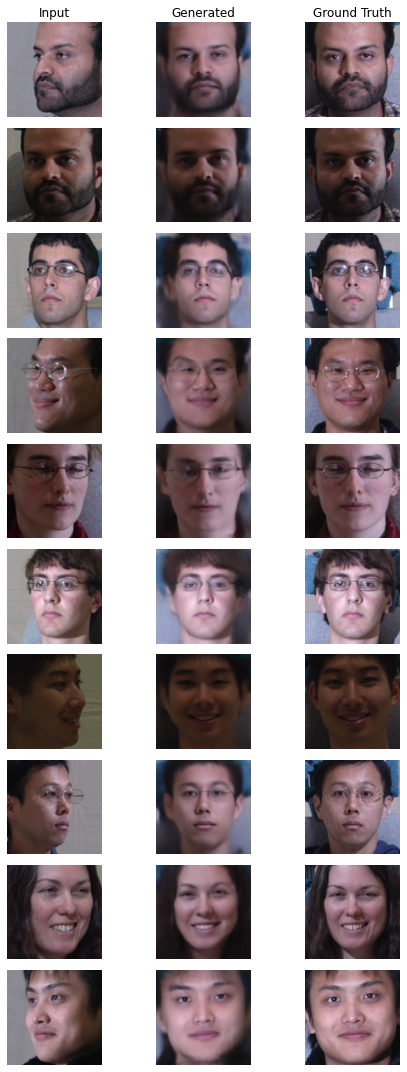

In [74]:
num_rows = len(img_list)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(7,1.5*num_rows))

cols = ['Input', 'Generated', 'Ground Truth']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

# Flatten the axes to iterate over them
axes = axes.flatten()

# Iterate over the image data and plot the images
for i, image_group in enumerate(img_list):
    axes[i * 3].imshow(image_group['input'].resize((512,512)), cmap='gray')
    axes[i * 3].axis('off')
    axes[i * 3 + 1].imshow(image_group['fake'].resize((512,512)), cmap='gray')
    axes[i * 3 + 1].axis('off')
    axes[i * 3 + 2].imshow(image_group['GT'].resize((512,512)), cmap='gray')
    axes[i * 3 + 2].axis('off')
fig.tight_layout()
if True:
    try:
        fig.savefig('image.png')
    except Exception as e:
        print("Couldn't save figure : {}".format(e))
plt.savefig("testimage.png")
plt.show()